In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import os
import gc
import time
import importlib
import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from recommender import item_based, preprocessing as rpp, model_selection as rms
import tag_genome_builder as tg_builder
from lib import tools
import config
def reload():
    importlib.reload(item_based)
    importlib.reload(config)
    importlib.reload(tg_builder)
    importlib.reload(rpp)
    importlib.reload(rms)
    importlib.reload(tools)


# input params

In [2]:
str_aggregated_path = r'C:\Users\shossein\Documents\personal\research\data\MA14KD_AGGREGATED.csv'
str_genome_scores = r'C:\Users\shossein\Documents\personal\research\data\ml-20m\genome-scores.csv'
str_tag_ids = r'C:\Users\shossein\Documents\personal\research\data\ml-20m\genome-tags.csv'
str_rating_path = r'C:\Users\shossein\Documents\personal\research\data\ml-20m\ratings.csv'
str_data_folder = r'C:\Users\shossein\Documents\personal\research\data'
minimum_no_of_frames = 10
number_of_tag_per_movie = 10

# Read inputs

In [3]:
df_tag_ids = pd.read_csv(str_tag_ids, index_col=config.tagId_col)

In [4]:
df_tag_ids.head()

,tag
tagId,
1,007
2,007 (series)
3,18th century
4,1920s
5,1930s


In [5]:
df_genome = pd.read_csv(str_genome_scores)

In [6]:
df_ratings = pd.read_csv(str_rating_path)

In [7]:
item_features = rpp.get_item_feature_from_tag_genome(df_genome, number_of_tag_per_movie)

In [8]:
df_ratings_filtered = df_ratings[df_ratings[config.movieId_col].isin(item_features.item_ids)]

# Train test split

In [9]:
reload()
df_rating_train, df_rating_test, item_features_train, item_features_test = \
    rms.train_test_split(df_ratings_filtered, item_features, strategy='sklearn', test_size=.25)

# Train recommender and predict on test

In [10]:
recommend = item_based.ItemBasedColabCos()
recommend.fit(df_rating_train, item_features_train)

In [11]:
test_users = df_rating_test[config.userId_col].unique()
recommendations = recommend.predict_on_list_of_users(test_users, df_rating_test, item_features_test, n_jobs=10)

In [12]:
df_rating_pred = pd.merge(df_rating_test, recommendations, on=[config.userId_col, config.movieId_col])

df_rating_pred['residual'] = df_rating_pred[config.rating_col] - df_rating_pred[f'{config.rating_col}_predicted']

In [35]:
df_rating_pred['absolute residual'] = df_rating_pred['residual'].abs()

In [21]:
no_of_null_predictions = df_rating_pred[f'{config.rating_col}_predicted'].isnull().sum()
share_of_null_predictions = df_rating_pred[f'{config.rating_col}_predicted'].isnull().mean()

if no_of_null_predictions > 0:
    print(f'Warning: {no_of_null_predictions} ({np.round(share_of_null_predictions * 100 , 2)}%)'
          ' ratings has no predicitons')

# looking at the performance

In [28]:
def drop_nulls(df):
    return df.dropna(subset=[f'{config.rating_col}_predicted'])

In [31]:
mae = metrics.regression.mean_absolute_error(drop_nulls(df_rating_pred)[config.rating_col], 
                                             drop_nulls(df_rating_pred)[f'{config.rating_col}_predicted'])
mse = metrics.regression.mean_squared_error(drop_nulls(df_rating_pred)[config.rating_col], 
                                             drop_nulls(df_rating_pred)[f'{config.rating_col}_predicted'])
rmse = np.sqrt(mse)
r2 = metrics.regression.r2_score(drop_nulls(df_rating_pred)[config.rating_col], 
                                             drop_nulls(df_rating_pred)[f'{config.rating_col}_predicted'])
mean = df_rating_pred[config.rating_col].mean()
nrmse = rmse / mean
residual_std = df_rating_pred['residual'].std()
residual_mean = df_rating_pred['residual'].mean()

# mse = metrics.regression.mean_squared_error(df_rating_pred[config.rating_col], df_rating_pred[f'{config.rating_col}_predicted'])
df_regression_report = pd.DataFrame({'Average Score': mean,
                                     'MAE': mae,
                                     'RMSE': rmse,
                                     'NRMSE': nrmse,
                                     'R2': r2,
                                     'Std of residuals': residual_std,
                                     'Avg of residuals': residual_mean
                                    },
                                     index=[''])
df_regression_report

,Average Score,MAE,RMSE,NRMSE,R2,Std of residuals,Avg of residuals
,3.528544,0.682246,0.888118,0.251695,0.285129,0.88802,-0.01318


Text(0.5, 1.0, 'Actual vs. predicted rating')

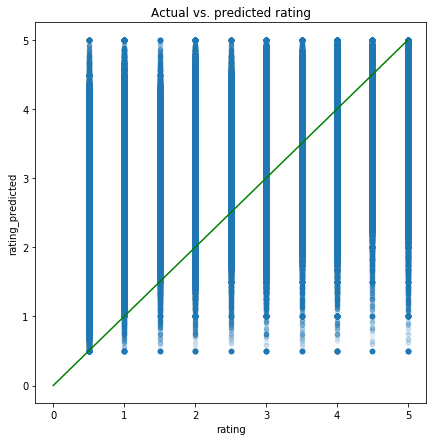

In [32]:
fig, ax = plt.subplots(figsize=(7,7))
df_rating_pred.plot.scatter(x=config.rating_col, y=f'{config.rating_col}_predicted', ax=ax, alpha=.1)
ax.plot([0,5], [0,5], color='g')
ax.set_title('Actual vs. predicted rating')

Text(0.5, 1.0, 'Residual plot')

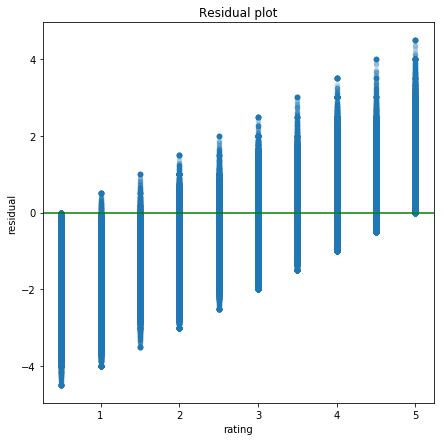

In [33]:
fig, ax = plt.subplots(figsize=(7,7))
df_rating_pred.plot.scatter(x=config.rating_col, y=f'residual', ax=ax, alpha=.1)
ax.axhline(0, color='g')
ax.set_title('Residual plot')

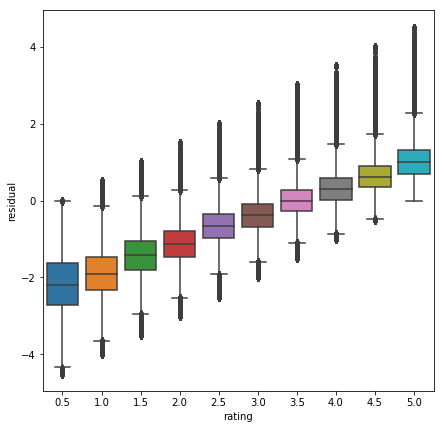

In [34]:
fig, ax = plt.subplots(figsize=(7,7))
sns.boxplot(x=config.rating_col, y='residual', data=df_rating_pred)

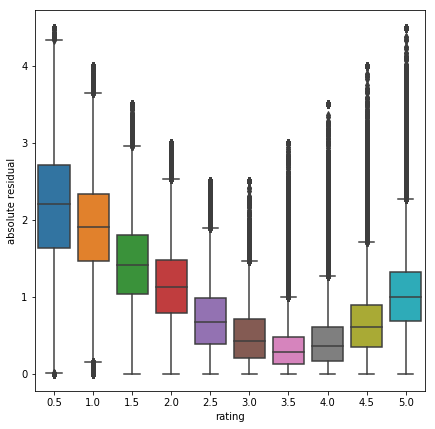

In [36]:
fig, ax = plt.subplots(figsize=(7,7))
sns.boxplot(x=config.rating_col, y='absolute residual', data=df_rating_pred)

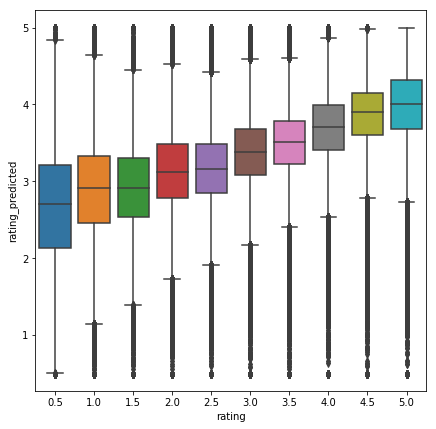

In [37]:
fig, ax = plt.subplots(figsize=(7,7))
sns.boxplot(x=config.rating_col, y=f'{config.rating_col}_predicted', data=df_rating_pred)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


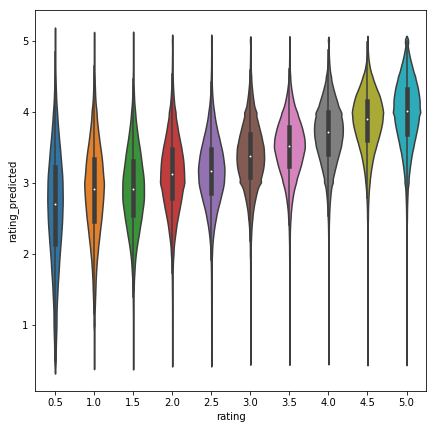

In [38]:
fig, ax = plt.subplots(figsize=(7,7))
sns.violinplot(x=config.rating_col, y=f'{config.rating_col}_predicted', data=df_rating_pred)